In [155]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sqlite3
import random
from scipy.stats import bootstrap, permutation_test
import seaborn as sns
from scipy import stats
sns.set()

In [24]:
path = '/Users/liqingyang/nyu_courses/intro_to_ds_gs/data_analysis_1/movieReplicationSet.csv'
# Significance level at 0.005 as specified
alpha = 0.005

all_docs = pd.read_csv(path)
movies_ratings = all_docs.iloc[:, :400]
sensation_seeking = all_docs.iloc[:, 400:421]
personality = all_docs.iloc[:,421:464]
movies_experience_ratings = all_docs.iloc[:,464:474]
gender = all_docs.iloc[:,474]
only_child = all_docs.iloc[:,475]
alone = all_docs.iloc[:,476]

### 1. Are movies that are more popular (operationalized as having more ratings) rated higher than movies that are less popular? [Hint: You can do a median-split of popularity to determine high vs. low popularity movies] 

In [123]:
# We will get the median by first getting the number of votes for each movie and then we get the median of these numbers
median_split = movies_ratings.notna().sum().median()

# Get a list of the movies that is less popular based on the median_split
all_movies_pop_index = movies_ratings.notna().sum().reset_index()
less_popular = all_movies_pop_index[all_movies_pop_index[0] < median_split]['index']
more_popular = all_movies_pop_index[all_movies_pop_index[0] >= median_split]['index']
mean_ratings_for_all_movies = movies_ratings.mean().reset_index().rename({'index': 'names', 0:'rating'}, axis=1)

l_p_list = less_popular.to_list()
m_p_list = more_popular.to_list()


### Solution: Independent T-test
- Since we are trying to see if popular groups have higher ratings rather than if they are differnt, we are doing a one-tail t-test.

1. Get the two lists of movies based on popularity (use median of the list of toal number of ratings received for each movie) and get the mean ratings for each movie.
2. Compute the difference between the two mean ratings based on popularity and set it as our test statistic.
3. Use independent t-test to get the t and p values

In [144]:
l_popular = movies_ratings.loc[:, l_p_list].mean().mean()
m_popular = movies_ratings.loc[:, m_p_list].mean().mean()
test_stat = m_popular-l_popular

In [172]:
# Separate the movies based on popularity and return an array with the mean ratings for each movie
lp = movies_ratings.loc[:, l_p_list].mean().to_numpy()
mp = movies_ratings.loc[:, m_p_list].mean().to_numpy()

# Individual t-test
t,p = stats.ttest_ind(lp, mp)

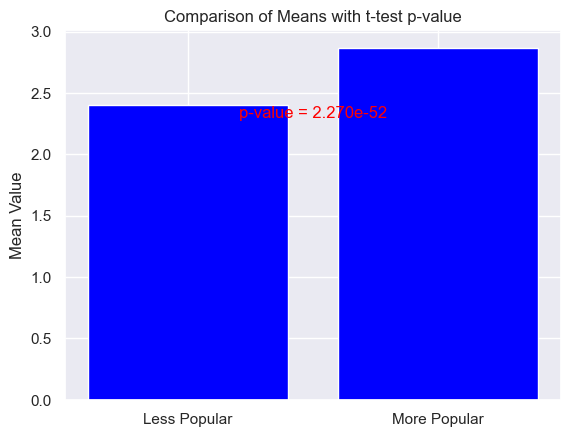

In [173]:
# Plotting the two means

labels = ['Less Popular', 'More Popular']
means = [np.mean(lp), np.mean(mp)]
colors = ['blue' if p < 0.005 else 'red' for _ in labels]

plt.bar(labels, means, color=colors)
plt.ylabel('Mean Value')
plt.title('Comparison of Means with t-test p-value')
plt.annotate(f'p-value = {p:.3e}', 
             xy=(0.5, max(means) * 0.8), 
             ha='center',
             color='red' if p < 0.005 else 'black')

plt.show()

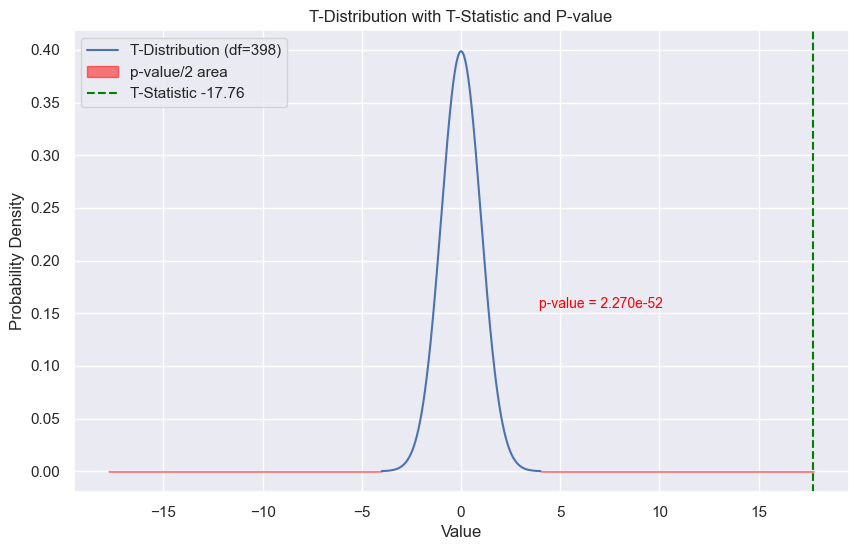

In [174]:
# Define t-distribution range and PDF
df = len(lp) + len(mp) - 2  
x = np.linspace(-4, 4, 1000)
y = stats.t.pdf(x, df)

# Plot t-distribution
plt.figure(figsize=(10, 6))
plt.plot(x, y, label=f'T-Distribution (df={df})')

# Highlight area for p-value and t-statistic
x_fill_left = np.linspace(-4, -abs(t), 1000)
x_fill_right = np.linspace(abs(t), 4, 1000)
plt.fill_between(x_fill_left, stats.t.pdf(x_fill_left, df), color='red', alpha=0.5, label='p-value/2 area')
plt.fill_between(x_fill_right, stats.t.pdf(x_fill_right, df), color='red', alpha=0.5)

# Add t-statistic as vertical dotted line
plt.axvline(-t, color='green', linestyle='--', label=f'T-Statistic {t:.2f}')

plt.annotate(f'p-value = {p:.3e}', 
             xy=(0.6, 0.4), 
             xycoords='axes fraction', 
             fontsize=10, 
             color='red')

plt.xlabel('Value')
plt.ylabel('Probability Density')
plt.title('T-Distribution with T-Statistic and P-value')
plt.legend()
plt.grid(True)

plt.show()

### Answer: it is different, 

### 2) Are movies that are newer rated differently than movies that are older? [Hint: Do a median split of year of release to contrast movies in terms of whether they are old or new]

### Solution: Permutation
1. Get the two lists of movies based on released year (use median of the list of all release years for all movies) and get the mean ratings for each movie.
2. Compute the difference between the two mean ratings based on the threshold for release year and set it as our test statistic.
3. Use permutation test

In [182]:
import regex as re

In [197]:
release_year_df.sort_values('year')

,names,year
17,Psycho (1960),1960
122,The Good the Bad and the Ugly (1966),1966
135,The Silencers (1966),1966
162,Who's Afraid of Virginia Woolf (1966),1966
268,Thoroughly Modern Millie (1967),1967
...,...,...
371,Captain America: Civil War (2016),2016
259,Ouija: Origin of Evil (2016),2016
225,Split (2016),2016
319,La La Land (2016),2016


In [223]:
# We first select the years from the columns, which are the names of the movies
release_years = np.array([int(i[-5:-1]) for i in all_movies])
# median_release_year = np.median(release_years)

# Store all release years and movies as a dataframe and separate them by half after sorted by years
release_year_df = pd.DataFrame({"names":all_movies, "year":release_years})
release_year_df.sort_values('year', inplace=True)

# The first 200 movies are the earliest 
old = release_year_df.iloc[:200, :].names.to_list()
new = release_year_df.iloc[200:, :].names.to_list()

old_movies_mean_ratings = movies_ratings.loc[:, old].mean()
new_movies_mean_ratings = movies_ratings.loc[:, new].mean()
test_stat = new_movies_mean_ratings.mean() - old_movies_mean_ratings.mean()

In [231]:
num_reps = int(1e4) # same number as before
sample_n = 200


rng = np.random.default_rng(69420)
shuffled_stats = []
for i in range(num_reps): # loop thru each
    shuffled_indices = rng.permutation(sample_n * 2) # randomly shuffle n2
    
    shuffled_group_1 = [all_movies[i] for i in shuffled_indices[:sample_n]]
    shuffled_group_2 = [all_movies[i] for i in shuffled_indices[sample_n:]]
    
    old = movies_ratings.loc[:, shuffled_group_1].mean()
    new = movies_ratings.loc[:, shuffled_group_2].mean()
    
    shuffled_stats.append(np.mean(new) - np.mean(old))

In [232]:
test_stat

0.05954464365175305

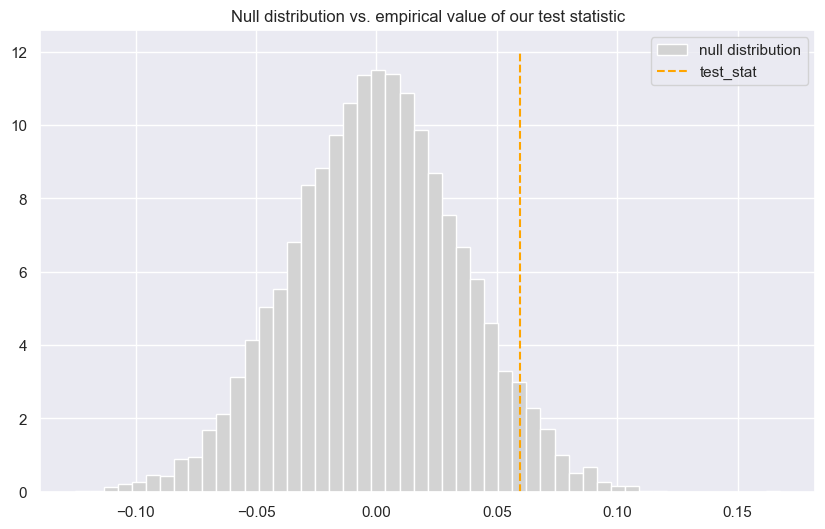

In [237]:
plt.figure(figsize=(10,6))
plt.hist(shuffled_stats, bins=50, density=True, color='lightgrey', label='null distribution')
plt.vlines(test_stat, 0, 12, color='orange', ls='--', label='test_stat')
plt.title('Null distribution vs. empirical value of our test statistic')
plt.legend()
plt.show()

In [246]:
p_val = len(np.argwhere(shuffled_stats>=test_stat))/num_reps
print('p-val:', p_val)

p-val: 0.0477


In [245]:
def test_stat_func(x,y):
    return np.mean(x) - np.mean(y)
old_np = old_movies_mean_ratings.to_numpy()
new_np = new_movies_mean_ratings.to_numpy()

test_data = (new_np, old_np)
p_test = permutation_test(test_data, test_stat_func, n_resamples=int(1e4), random_state=69420)    
print('Test stat:', p_test.statistic)
print('P-val:',p_test.pvalue)

# at home: change the number of repeats and note the stability of the results and how they 
# change as a function of the number of repeats.
# by default, this is two-tailed.

Test stat: 0.05954464365175305
P-val: 0.09499050094990501


In [242]:
np.argwhere(shuffled_stats>=test_stat)

array([[  13],
       [  18],
       [  31],
       [ 103],
       [ 123],
       [ 131],
       [ 139],
       [ 210],
       [ 233],
       [ 237],
       [ 246],
       [ 293],
       [ 319],
       [ 344],
       [ 414],
       [ 419],
       [ 427],
       [ 461],
       [ 469],
       [ 478],
       [ 493],
       [ 509],
       [ 543],
       [ 567],
       [ 570],
       [ 581],
       [ 592],
       [ 595],
       [ 638],
       [ 651],
       [ 677],
       [ 678],
       [ 699],
       [ 747],
       [ 765],
       [ 769],
       [ 790],
       [ 797],
       [ 804],
       [ 858],
       [ 892],
       [ 894],
       [ 897],
       [ 927],
       [ 954],
       [ 972],
       [ 991],
       [1001],
       [1011],
       [1012],
       [1019],
       [1044],
       [1110],
       [1152],
       [1177],
       [1199],
       [1226],
       [1239],
       [1253],
       [1293],
       [1301],
       [1320],
       [1337],
       [1341],
       [1361],
       [1366],
       [13

In [239]:
p_val = len(np.argwhere(shuffled_stats>=test_stat))/num_reps
print('p-val:', p_val)

p-val: 0.0477


In [141]:
shuffled_group_1

['King Kong (1976)',
 "Harry Potter and the Sorcerer's Stone (2001)",
 'Cocktail (1988)',
 'Gone in Sixty Seconds (2000)',
 'Diamonds are Forever (1971)',
 'War Games (1983)',
 'The Three Musketeers (1993)',
 'Battlefield Earth (2000)',
 'Clueless (1995)',
 'The Lord of the Rings: The Two Towers (2002)',
 'Men in Black II (2002)',
 '25th Hour (2002)',
 'Aladdin (1992)',
 'Thoroughly Modern Millie (1967)',
 'The Bridges of Madison County (1995)',
 '10 Things I Hate About You (1999)',
 'The Passenger (1975)',
 'Taxi Driver (1976)',
 'Reservoir Dogs (1992)',
 'Harry Potter and the Chamber of Secrets (2002)',
 'Funny Girl (1968)',
 'Red Sonja (1985)',
 'JFK (1991)',
 'Full Metal Jacket (1987)',
 'Indiana Jones and the Temple of Doom (1984)',
 'The Texas Chainsaw Massacre (1974)',
 'The Proposal (2009)',
 'The Core (2003)',
 'Rocky (1976)',
 'Mystic River (2003)',
 'Andaz Apna Apna (1994)',
 'Mission: Impossible II (2000)',
 'E.T. The Extra-Terrestrial (1982)',
 'Anaconda (1997)',
 'The Sti

In [139]:
all_movies

['The Life of David Gale (2003)',
 'Wing Commander (1999)',
 'Django Unchained (2012)',
 'Alien (1979)',
 'Indiana Jones and the Last Crusade (1989)',
 'Snatch (2000)',
 'Rambo: First Blood Part II (1985)',
 'Fargo (1996)',
 'Let the Right One In (2008)',
 'Black Swan (2010)',
 'King Kong (1976)',
 'The Machinist (2004)',
 'A Nightmare on Elm Street (1984)',
 'Brazil (1985)',
 'The Fast and the Furious (2001)',
 'Change of Habit (1969)',
 'American Beauty (1999)',
 'Psycho (1960)',
 'Terminator 3: Rise of the Machines (2003)',
 'Night of the Living Dead (1968)',
 'Man on Fire (2004)',
 'Star Wars: Episode IV - A New Hope (1977)',
 'The Silence of the Lambs (1991)',
 'The Others (2001)',
 'Minority Report (2002)',
 'Sling Blade (1996)',
 "Schindler's List (1993)",
 '3000 Miles to Graceland (2001)',
 'Magnolia (1999)',
 'The Karate Kid Part II (1986)',
 'Planet of the Apes (2001)',
 'The Godfather: Part II (1974)',
 'Indiana Jones and the Temple of Doom (1984)',
 'Indiana Jones and the R

In [138]:
shuffled_indices[:sample_n]

array([ 10, 230, 356,  76,  61, 175, 136, 194,  55, 198, 355, 161, 350,
       268,  43, 201, 368,  39, 308, 394,  77, 359, 118,  96,  32,  38,
       112, 263, 265, 108, 111,  51, 344, 396, 280, 382, 304, 337, 338,
       115, 284, 385, 200, 215, 151, 105,  91, 163, 258, 199, 270,  65,
       169,  63, 345, 144, 269,  35, 197,  82,  93, 384, 273, 313, 180,
       319, 353, 315, 288, 125, 293, 289, 395, 243,  97, 207, 369, 311,
       110, 321, 295, 205, 312, 330, 221, 245, 358, 366,  28, 234, 191,
       299, 339,  26, 399, 231, 303, 166,  41, 291, 329, 168, 397, 360,
       181, 389,  99, 196,  58, 174, 100,  84, 251,  23, 247, 283, 173,
       322, 218, 297, 307,  48, 104,  59, 352, 164,   4, 179, 370, 254,
        34, 332, 190,  70, 114,  89, 287, 122, 223,  83,  53, 220, 193,
       236, 121, 357, 398, 178, 154, 309, 341, 237, 156, 381, 274, 238,
       378, 203, 383,   1, 300, 132,  52, 246, 124,  85, 278, 242, 113,
       188,  25, 281, 372, 145, 171, 103,   2,  78, 189, 327, 21

In [135]:
rng = np.random.default_rng(69420)
rng.permutation(200)

array([192,  41, 105,  27, 193, 122, 114,  77, 136,  42,  26,   2,  63,
       154, 119,  39,  17, 157, 100, 151, 158, 104,  54,  88, 196,  76,
        82, 142, 173,  85,  99, 110, 118, 195, 199,  89,  66,  83,  33,
       125, 111, 189,  95, 177,  93,  91, 133, 184, 153, 172, 163,  25,
        43, 186,  51,  53,  28,  80,  78,  61,   1, 103,  47,  65,  79,
       181,  32, 107,  48, 113,  73, 139,  52, 198,  59, 169, 191,  12,
       112,  97, 127, 161,  35,  11, 180,  81, 185,  58,  94,  36,  55,
       146, 145, 197, 120,  96,  22,   3,  86, 135, 190,   8,  38, 166,
        10, 137, 183,  74,  14, 171,   4, 117, 164, 131, 141,  56,  57,
       179, 126, 115, 156, 178,  16, 194,   0,  75,  60,  45,  34, 176,
        44,  71, 152, 148, 167,   5, 106, 129,  29,  92,  20,  68, 121,
        67,  90,  37, 124,   6,  98, 134,   7, 149,  87,  19,  72, 144,
       116, 188, 150, 123, 128, 109, 174,  23,  84, 162,  18, 101,  50,
       165,  46, 102, 140, 170, 130, 147,  21, 159,  24,  69,   

In [124]:
def test_stat_func(x,y):
    return np.mean(x) - np.mean(y)

test_data = (matrix_2, matrix_3)
p_test = permutation_test(test_data, test_stat_func, n_resamples=int(1e4), random_state=69420)    
print('Test stat:', p_test.statistic)
print('P-val:',p_test.pvalue)

# at home: change the number of repeats and note the stability of the results and how they 
# change as a function of the number of repeats.
# by default, this is two-tailed.

,names,rating
0,The Life of David Gale (2003),2.151316
1,Wing Commander (1999),2.021127
2,Django Unchained (2012),3.153422
3,Alien (1979),2.707612
4,Indiana Jones and the Last Crusade (1989),2.778618
...,...,...
395,Patton (1970),2.278689
396,Anaconda (1997),2.295455
397,Twister (1996),2.402299
398,MacArthur (1977),2.114754
